# Version Notes

- V4 fixes a bug in the way cps was scraped from text
- V3 includes only code to run and assess the agents
- V2 includes code to test components of the agents

# Overview
    
    
- Write post and tag https://twitter.com/Orteil42 and the cookie clicker twitter in final post

## Setup

[chrome driver](http://chromedriver.chromium.org/downloads)

`selenium` library...









In [1]:
# general web wrangling
import selenium  # another approach
from selenium import webdriver
# for mousing over an element
from selenium.webdriver.common.action_chains import ActionChains

# for text processing
import re

# for plotting 
import matplotlib.pyplot as plt

# for clearing feedback
from IPython.display import clear_output

# for saving and loading data including dicts
import pickle
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

# for notification tones; 
import pyaudio
import numpy as np
import time
# for audio notifications when action required
def notify_tone(reps=1,sleep=.25,volume=1,fs=44100,duration=.5,f=600):
    p = pyaudio.PyAudio()
    # generate samples, note conversion to float32 array
    samples = (np.sin(2*np.pi*np.arange(fs*duration)*f/fs)).astype(np.float32)
    # for paFloat32 sample values must be in range [-1.0, 1.0]
    stream = p.open(format=pyaudio.paFloat32,
                    channels=1,
                    rate=fs,
                    output=True)
    # play. May repeat with different volume values (if done interactively) 
    for i in range(reps): stream.write(volume*samples); time.sleep(sleep)
    stream.stop_stream()
    stream.close()
    p.terminate()

# Cookie Clicker Naive Agent

This clicker checks items after a specified number of clicks, and buys all affordible items, starting the the most recently unlocked buildings.

In [2]:
# Naive agent
class agent_class_naive:
    def __init__(self,driver):
        # navigate to site
        driver.get('https://orteil.dashnet.org/cookieclicker/')
        time.sleep(10) # time for page to load
        self.big_cookie = driver.find_element_by_id('bigCookie')
        self.golden_cookie_clicks = 0
        # initialize balance and revenue variables
        self.balance=0
        self.revenue=0 
        # initialize balance and revenue logs
        self.log_balance=[0]
        self.log_revenue=[0]
        self.log_bal_rev_epoch=[0]
        # initialize building info, and logs of building info
        self.get_building_info()
        self.log_build_info = dict()
        self.building_info_logger(epoch=0)
        
        # CHANGE GRAPHICS AND OTHER SETTINGS
        # click 'options' tab
        driver.find_element_by_id("prefsButton").click()
        time.sleep(1) # let page load
        # disable text instead of numbers, e.g. 'million' -> '000,000'
        driver.find_element_by_id("numbersButton").click()
        # slide volume to around 25%
        time.sleep(.5) # so actions don't happen too fast
        volume = driver.find_element_by_class_name("slider")
        move = ActionChains(driver)
        move.click_and_hold(volume).move_by_offset(-50, 0).release().perform()
        # change graphics for optimal performance
        buttons = ("fancyButton","particlesButton","cursorsButton",
                  "milkButton","wobblyButton","cookiesoundButton",
                  "formatButton","extraButtonsButton","customGrandmasButton")
        for button in buttons:
            time.sleep(.5) # so actions don't happen too fast to execute
            driver.find_element_by_id(button).click()
        
    def click_cookie(self):
        self.big_cookie.click()
        
    def click_golden_cookie(self):
        golden_cookies = driver.find_elements_by_xpath('//div[@class="shimmer"]')
        while len(golden_cookies)>0: # if there are products, and while we can afford products,
            for golden_cookie in golden_cookies:
                golden_cookie.click() # buy each one
                self.golden_cookie_clicks+=1
            golden_cookies = driver.find_elements_by_xpath('//div[@class="shimmer"]')
    
    def buy_upgrades(self):
        upgrades = driver.find_elements_by_xpath('//div[@class="crate upgrade enabled"]')
        while len(upgrades)>0: # if there are products, and while we can afford products,
            try: upgrades[-1].click() # buy each one, most expensive first
            except: None
            upgrades = driver.find_elements_by_xpath('//div[@class="crate upgrade enabled"]')
    
    def buy_products(self):
        products = driver.find_elements_by_xpath('//div[@class="product unlocked enabled"]')
        while products: # if there are affordible products, buy them
            products[-1].click()
            products = driver.find_elements_by_xpath('//div[@class="product unlocked enabled"]')
        #while len(products)>0: # if there are products, and while we can afford products,
        #    try: products[-1].click() # buy each one, most expensive first
        #    except: None
        #    products = driver.find_elements_by_xpath('//div[@class="product unlocked enabled"]')
            
    def log_balance_and_revenue(self,epoch=None):
        # log balance and revenue
        tmp = driver.find_elements_by_xpath('//div[@id="cookies"]')
        tmp = tmp[0].text.replace(',','') # remove camas 1,000 -> 1000
        tmp = re.findall("\d+",tmp) # extract balance and revenue
        tmp = [int(i) for i in tmp] # convert str -> int
        self.balance = tmp[0] # update current balance
        self.revenue = tmp[1] # new for min_wait agent
        if epoch: # epoch passed when this is called to log info, not just to update balance
            self.log_bal_rev_epoch.append(epoch) # index for balance and revenue
            self.log_balance.append(tmp[0]) # log balance
            self.log_revenue.append(tmp[1]) # log revenue

    def get_building_info(self):
        # get unlocked products
        products_unlocked = (driver.find_elements_by_xpath('//div[@class="product unlocked enabled"]') + 
                             driver.find_elements_by_xpath('//div[@class="product unlocked disabled"]'))
        # info for unlocked buildings
        building_info = dict()
        for i,building in enumerate(products_unlocked):
            # get info from building button
            tmp=building.text.replace(',','').split(sep="\n")
            building_name,building_price,building_count = tmp if len(tmp)==3 else tmp+[0]
            # initialize dict for building
            building_info[building_name] = dict()
            # fill in count and price
            building_info[building_name]['count']=int(building_count)
            building_info[building_name]['price']=int(building_price)
            # get info from building tooltip
            hover = ActionChains(driver).move_to_element(building)
            hover.perform()
            tooltip = driver.find_elements_by_xpath('//div[@id="tooltip"]')
            tmp=tooltip[0].text.replace(',','');
            # tmp_cps = re.findall(r"[-+]?\d*\.\d+ cookies per|\d+ cookies per",tmp)
            # ^ fails for grandmas because of their text
            tmp_cps  = re.findall(r"produces [-+]?\d*\.\d+|produces \d+",tmp);
            # > 'produces X'
            if tmp_cps: # if building has been purchased
                tmp_cps_2=float(re.findall(r"[-+]?\d*\.\d+|\d+",tmp_cps[0])[0])
                building_cps = tmp_cps_2
            else: # if building hasn't been purchased, store cps as infinity
                building_cps = float('inf')
            # > X
            #### default of inf below encourages purchasing unlocked, unowned buildings
            #building_cps = float(tmp_cps[0][:tmp_cps[0].find(' ')]) if tmp_cps else float('inf')
            building_info[building_name]['cps']=building_cps
            building_info[building_name]['cps/price']=building_cps/int(building_price)
        self.building_info = building_info
        
    def building_info_logger(self,epoch):
        if self.building_info: # if self.building_info exists
            # modified from get_building_info to append.
            log_keys = ['count','price','cps','cps/price']
            # info for unlocked buildings
            for building in self.building_info:
                # initialize new buildings
                if building not in self.log_build_info:
                    self.log_build_info[building] = dict()
                    for k in log_keys+['epoch']:
                        self.log_build_info[building][k]=[]
                # fill in count,price,cps, cps/price
                for k in log_keys:
                    self.log_build_info[building][k].append(self.building_info[building][k])
                # log epoch, within each building since buildings become available at different times
                self.log_build_info[building]['epoch'].append(epoch)


In [3]:
# start driver
driver = webdriver.Chrome('./chromedriver')

In [4]:
# initialize agent
agent = agent_class_naive(driver)

In [5]:
#### turn off all default graphic settings!! 

In [6]:
# initialize click counter
ci = 0

In [7]:
# run algorithm for a specified number of cookie clicks
clicks = 100000
t0=time.time()
initial_ci = ci
stop = ci+clicks # run for `clicks` additional clicks
while ci<stop:
    ci += 1 # increment click counter
    agent.click_cookie()
    #agent.click_golden_cookie()
    if ci%200 == 0: # to speed pure clicking
        #agent.buy_upgrades()
        agent.buy_products()
        # log data
        agent.log_balance_and_revenue(ci)
        agent.get_building_info()
        agent.building_info_logger(epoch=ci)
        # feedback
        clear_output()
        print('click: '+str(ci-initial_ci)+' of '+str(stop-initial_ci)+
             '\npct: '+str((ci-initial_ci)/(stop-initial_ci))+
             '\nGolden Clicks: '+str(agent.golden_cookie_clicks))
    #time.sleep(.07) # to keep CPU usage sustainably low
t1=time.time()
print('Total Time: '+ str(t1-t0) +'sec')
# alert that loop finished
notify_tone(reps=3,sleep=.5)

click: 100000 of 100000
pct: 1.0
Golden Clicks: 0
Total Time: 3668.027375936508sec


In [8]:
driver.close()

In [9]:
# save the agent for later analysis:
# locally store this temporary agent as agent_naive
agent_naive=agent
# can't pickle web object, so need to clear agent.big_cookie before saving
agent_naive.big_cookie, tmp = [],agent_naive.big_cookie
save_obj(agent_naive,"agent_naive_no_golden_no_upgrade")
agent_naive.big_cookie = tmp

In [10]:
# load the agent from the above save
# was getting UTF-8 error, 
# changed to ... 'r',,encoding='utf-16') ...
# this didn't help, but it worked when changed back to ...'rb')?

agent = load_obj("agent_naive_no_golden_no_upgrade")

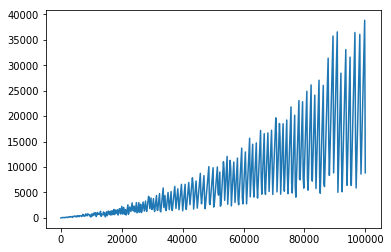

In [11]:
plt.plot(agent.log_bal_rev_epoch,agent.log_balance)

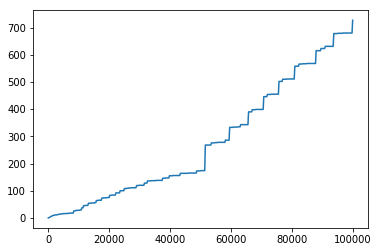

In [12]:
# outliers here can be due to golden cookies
plt.plot(agent.log_bal_rev_epoch,agent.log_revenue)
#plt.scatter(agent.bal_rev_epoch,agent.log_revenue)

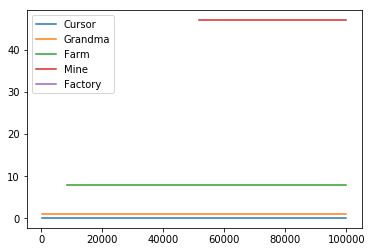

In [13]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['cps'],label=k)
plt.legend()

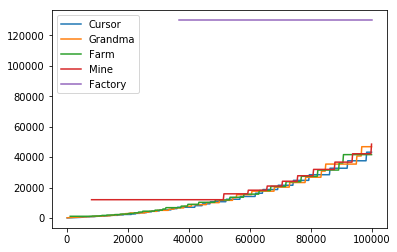

In [14]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['price'],label=k)
plt.legend()

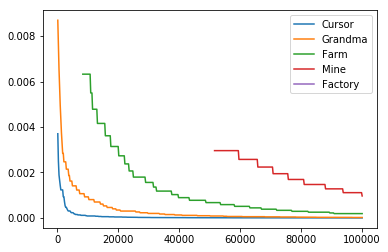

In [15]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['cps/price'],label=k)
plt.legend()

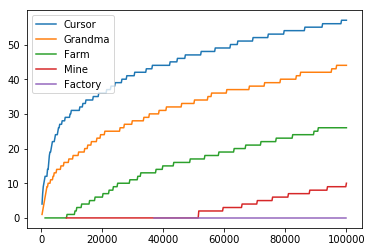

In [16]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['count'],label=k)
plt.legend()

# Cookie Clicker Max RPS/Price Agent


- This clicker buys unlocked buildings with the highest cookies per second to price ratio. 

- Queue purchases based on maximum RPS/price


In [17]:
# Max RPS/price agent
class agent_class_max_rps_price_ratio(agent_class_naive):
    # overwrite the buy_products method
    def buy_products(self):
        ## update building info
        self.get_building_info()
        # while best is affordible, buy the best rps/price building
        best_building_affordible = True
        while best_building_affordible:
            ## get unlocked products
            products = (driver.find_elements_by_xpath('//div[@class="product unlocked enabled"]') + 
                        driver.find_elements_by_xpath('//div[@class="product unlocked disabled"]'))
            # find max rps/price building
            max_rps_pp,building_to_buy,product_to_buy = 0,[],[]
            for i,building in enumerate(self.building_info):
                # get rps/price for building
                cur_rps_pp = self.building_info[building]['cps/price'] 
                # if it's the best so far, update max and building id
                if cur_rps_pp > max_rps_pp:
                    max_rps_pp,building_to_buy = cur_rps_pp,building
                    product_to_buy = products[i] # store element to click
            # update balance
            self.log_balance_and_revenue()
            # check if best building is affordible.
            if self.building_info[building_to_buy]['price']<=self.balance:
                # buy building_to_buy (click on this product)
                product_to_buy.click()
                # update building info (including rps per price rps_pp)
                self.get_building_info()
            else: best_building_affordible=False # if not affordible, break the loop        
                
                


In [18]:
# start driver
driver = webdriver.Chrome('./chromedriver')

In [ ]:
# initialize agent
agent = agent_class_max_rps_price_ratio(driver)

In [ ]:
#### turn off all default graphic settings!! 

In [ ]:
# initialize click counter
ci = 0

In [ ]:
# run algorithm for a specified number of cookie clicks
clicks = 100000-ci
t0=time.time()
initial_ci = ci
stop = ci+clicks # run for `clicks` additional clicks
while ci<stop:
    ci += 1 # increment click counter
    agent.click_cookie()
    #agent.click_golden_cookie()
    if ci%200 == 0: # to speed pure clicking
        #agent.buy_upgrades()
        agent.buy_products()
        # log data
        agent.log_balance_and_revenue(epoch=ci)
        agent.get_building_info()
        agent.building_info_logger(epoch=ci)
        # feedback
        clear_output()
        print('click: '+str(ci-initial_ci)+' of '+str(stop-initial_ci)+
             '\npct: '+str((ci-initial_ci)/(stop-initial_ci))+
             '\nGolden Clicks: '+str(agent.golden_cookie_clicks))
    #time.sleep(.07) # to keep CPU usage sustainably low
t1=time.time()
print('Total Time: '+ str(t1-t0) +'sec')
# alert that loop finished
notify_tone(reps=3,sleep=.5)

click: 100000 of 100000
pct: 1.0
Golden Clicks: 0
Total Time: 3785.779732942581sec


In [ ]:
driver.close()

In [ ]:
# save the agent for later analysis:
# # locally store this temporary agent as agent_naive
agent_max_cps_per_price=agent
# # can't pickle web object, so need to clear agent.big_cookie before saving
agent_max_cps_per_price.big_cookie, tmp = [],agent_max_cps_per_price.big_cookie
save_obj(agent_max_cps_per_price,"agent_max_cps_per_price_no_golden_no_upgrade")
agent_max_cps_per_price.big_cookie = tmp

In [ ]:
# load the agent from the above save
# was getting UTF-8 error, 
# changed to ... 'r',,encoding='utf-16') ...
# this didn't help, but it worked when changed back to ...'rb')?

agent = load_obj("agent_max_cps_per_price_no_golden_no_upgrade")

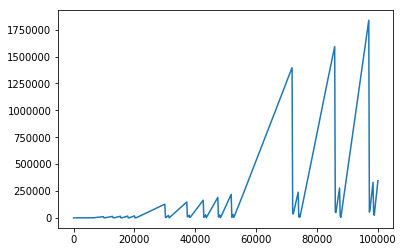

In [ ]:
plt.plot(agent.log_bal_rev_epoch,agent.log_balance)

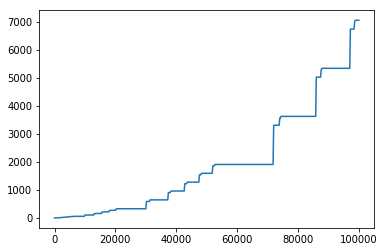

In [ ]:
# outliers here can be due to golden cookies
plt.plot(agent.log_bal_rev_epoch,agent.log_revenue)
#plt.scatter(agent.bal_rev_epoch,agent.log_revenue)

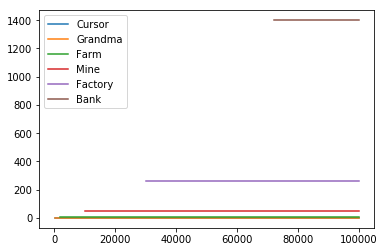

In [ ]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['cps'],label=k)
plt.legend()

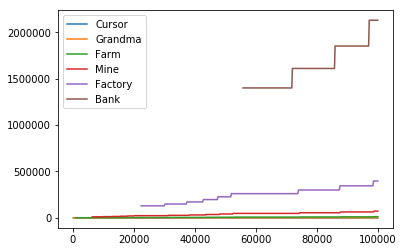

In [ ]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['price'],label=k)
plt.legend()

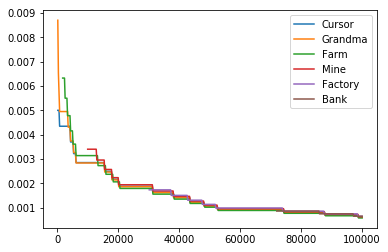

In [ ]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['cps/price'],label=k)
plt.legend()

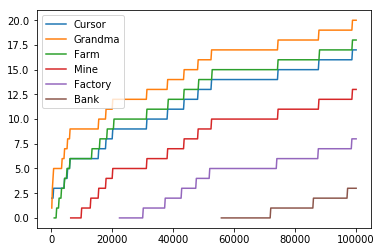

In [ ]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['count'],label=k)
plt.legend()

- The long flat lines are periods when the agent was waiting to save enough to buy an expensive item, or when they were spending a lot on upgrades.

# Cookie Clicker min wait time until max rps purchase


- Queue purchases to minimuze wait time until buying the maximum rps option


In [ ]:
# Max RPS/price agent
class agent_class_min_wait(agent_class_naive):
    # overwrite the buy_products method for this agent's purchase logic
    def buy_products(self):
        ## update building info
        self.get_building_info()
        # while best building affordible, buy it and look for next best building
        best_building_affordible = True
        while best_building_affordible:
            ## get unlocked products
            products = (driver.find_elements_by_xpath('//div[@class="product unlocked enabled"]') + 
                        driver.find_elements_by_xpath('//div[@class="product unlocked disabled"]'))
            # find building with max revenue per second and it's cost
            max_rps,cost_max_rps = 0, float('inf')
            building_to_buy,product_to_buy = [], []
            for i,building in enumerate(self.building_info):
                # get rps for building
                cur_rps = self.building_info[building]['cps'] 
                # if it's the best rps far, update max, cost, and building id
                if cur_rps > max_rps:
                    max_rps,building_to_buy = cur_rps,building
                    cost_max_rps = self.building_info[building]['price'] 
                    product_to_buy = products[i] # queue this building to buy

            # update revenue for computations below
            self.log_balance_and_revenue()
            # check if any other purchase would reduce wait time to buying max_rps product
            wait_max = float(cost_max_rps) / self.revenue if self.revenue else 0 # stops division by 0
            
            print((building_to_buy,self.building_info[building_to_buy]['cps'],wait_max))
            
            for i,building in enumerate(self.building_info):
                cost_cur = self.building_info[building]['price']
                rps_cur  = self.revenue + self.building_info[building]['cps']
                # conditional to stop division by 0
                wait_till_cur = float(cost_cur) / self.revenue if self.revenue else 0
                wait_cur = (wait_till_cur + 
                             cost_max_rps / rps_cur)
                if wait_cur <= wait_max: 
                    wait_max = wait_cur # update minimum wait
                    building_to_buy = building
                    
                    print((building_to_buy,self.building_info[building_to_buy]['cps'],wait_cur))
                    
                    product_to_buy = products[i] # queue this building to buy instead
            # update balance for checking if building affordible
            self.log_balance_and_revenue()
            # buy either max_rps product, or the building that would reduce wait time
            # check if best building is affordible
            if self.building_info[building_to_buy]['price']<=self.balance:
                # buy building_to_buy (click on this product)
                product_to_buy.click()
                # update building info (including rps per price rps_pp)
                self.get_building_info()
            else: best_building_affordible=False # if not affordible, break purchase loop     
        

In [ ]:
# start driver
driver = webdriver.Chrome('./chromedriver')

In [ ]:
# initialize agent
agent = agent_class_min_wait(driver)

In [ ]:
#### turn off all default graphic settings!! 

In [ ]:
# initialize click counter
ci = 0

In [ ]:
# run algorithm for a specified number of cookie clicks
clicks = 100000-ci
t0=time.time()
initial_ci = ci
stop = ci+clicks # run for `clicks` additional clicks
while ci<stop:
    ci += 1 # increment click counter
    agent.click_cookie()
    #agent.click_golden_cookie()
    if ci%200 == 0: # to speed pure clicking
        #agent.buy_upgrades()
        agent.buy_products()
        # log data
        agent.log_balance_and_revenue(epoch=ci)
        agent.get_building_info()
        agent.building_info_logger(epoch=ci)
        # feedback
        #clear_output()
        print('click: '+str(ci-initial_ci)+' of '+str(stop-initial_ci)+
             '\npct: '+str((ci-initial_ci)/(stop-initial_ci))+
             '\nGolden Clicks: '+str(agent.golden_cookie_clicks))
    #time.sleep(.07) # to keep CPU usage sustainably low
t1=time.time()
print('Total Time: '+ str(t1-t0) +'sec')
# alert that loop finished
notify_tone(reps=3,sleep=.5)

('Cursor', inf, 0)
('Cursor', inf, 0.0)
('Grandma', inf, 0.0)
('Cursor', inf, 15.0)
('Cursor', inf, 15.0)
('Grandma', 1.0, 115.0)
click: 200 of 100000
pct: 0.002
Golden Clicks: 0
('Grandma', 1.0, 115.0)
('Grandma', 1.0, 66.5)
('Grandma', 1.0, 51.0)
click: 400 of 100000
pct: 0.004
Golden Clicks: 0
('Grandma', 1.0, 51.0)
('Grandma', 1.0, 43.75)
click: 600 of 100000
pct: 0.006
Golden Clicks: 0
('Grandma', 1.0, 43.75)
('Grandma', 1.0, 40.4)
('Grandma', 1.0, 40.4)
click: 800 of 100000
pct: 0.008
Golden Clicks: 0
('Grandma', 1.0, 40.4)
('Grandma', 1.0, 38.666666666666664)
('Grandma', 1.0, 38.666666666666664)
click: 1000 of 100000
pct: 0.01
Golden Clicks: 0
('Farm', inf, 183.33333333333334)
('Cursor', 0.1, 183.32786885245903)
('Farm', inf, 183.33333333333334)
('Farm', inf, 183.33333333333334)
click: 1200 of 100000
pct: 0.012
Golden Clicks: 0
('Farm', inf, 183.33333333333334)
('Farm', inf, 183.33333333333334)
click: 1400 of 100000
pct: 0.014
Golden Clicks: 0
('Farm', inf, 183.33333333333334)
(

click: 16200 of 100000
pct: 0.162
Golden Clicks: 0
('Mine', 47.0, 93.59487179487179)
click: 16400 of 100000
pct: 0.164
Golden Clicks: 0
('Mine', 47.0, 93.59487179487179)
click: 16600 of 100000
pct: 0.166
Golden Clicks: 0
('Mine', 47.0, 93.59487179487179)
click: 16800 of 100000
pct: 0.168
Golden Clicks: 0
('Mine', 47.0, 93.59487179487179)
click: 17000 of 100000
pct: 0.17
Golden Clicks: 0
('Mine', 47.0, 93.59487179487179)
click: 17200 of 100000
pct: 0.172
Golden Clicks: 0
('Mine', 47.0, 93.59487179487179)
click: 17400 of 100000
pct: 0.174
Golden Clicks: 0
('Mine', 47.0, 93.59487179487179)
click: 17600 of 100000
pct: 0.176
Golden Clicks: 0
('Mine', 47.0, 93.59487179487179)
('Mine', 47.0, 86.73140495867769)
click: 17800 of 100000
pct: 0.178
Golden Clicks: 0
('Mine', 47.0, 86.73140495867769)
click: 18000 of 100000
pct: 0.18
Golden Clicks: 0
('Mine', 47.0, 86.73140495867769)
click: 18200 of 100000
pct: 0.182
Golden Clicks: 0
('Mine', 47.0, 86.73140495867769)
click: 18400 of 100000
pct: 0.184

('Factory', inf, 373.5632183908046)
('Factory', inf, 373.5632183908046)
click: 30200 of 100000
pct: 0.302
Golden Clicks: 0
('Factory', inf, 373.5632183908046)
('Factory', inf, 373.5632183908046)
click: 30400 of 100000
pct: 0.304
Golden Clicks: 0
('Factory', inf, 373.5632183908046)
('Factory', inf, 373.5632183908046)
click: 30600 of 100000
pct: 0.306
Golden Clicks: 0
('Factory', inf, 373.5632183908046)
('Factory', inf, 373.5632183908046)
click: 30800 of 100000
pct: 0.308
Golden Clicks: 0
('Factory', inf, 373.5632183908046)
('Factory', inf, 373.5632183908046)
click: 31000 of 100000
pct: 0.31
Golden Clicks: 0
('Factory', inf, 373.5632183908046)
('Factory', inf, 373.5632183908046)
click: 31200 of 100000
pct: 0.312
Golden Clicks: 0
('Factory', inf, 373.5632183908046)
('Factory', inf, 373.5632183908046)
('Factory', 260.0, 245.88815789473685)
click: 31400 of 100000
pct: 0.314
Golden Clicks: 0
('Factory', 260.0, 245.88815789473685)
click: 31600 of 100000
pct: 0.316
Golden Clicks: 0
('Factory',

In [ ]:
driver.close()

In [ ]:
# save the agent for later analysis:
# # locally store this temporary agent as agent_naive
agent_max_cps_per_price=agent
# # can't pickle web object, so need to clear agent.big_cookie before saving
agent_max_cps_per_price.big_cookie, tmp = [],agent_max_cps_per_price.big_cookie
save_obj(agent_max_cps_per_price,"agent_min_wait_no_golden_no_upgrade")
agent_max_cps_per_price.big_cookie = tmp

In [ ]:
# load the agent from the above save
# was getting UTF-8 error, 
# changed to ... 'r',,encoding='utf-16') ...
# this didn't help, but it worked when changed back to ...'rb')?

agent = load_obj("agent_min_wait_no_golden_no_upgrade")

In [ ]:
plt.plot(agent.log_bal_rev_epoch,agent.log_balance)

In [ ]:
# outliers here can be due to golden cookies
plt.plot(agent.log_bal_rev_epoch,agent.log_revenue)
#plt.scatter(agent.bal_rev_epoch,agent.log_revenue)

In [ ]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['cps'],label=k)
plt.legend()

In [ ]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['price'],label=k)
plt.legend()

In [ ]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['cps/price'],label=k)
plt.legend()

In [ ]:
for k in agent.log_build_info:
    plt.plot(agent.log_build_info[k]['epoch'],agent.log_build_info[k]['count'],label=k)
plt.legend()

# Comparisons

In [ ]:
agent_naive    = load_obj("agent_naive_no_golden_no_upgrade")
agent_max_cps  = load_obj("agent_max_cps_per_price_no_golden_no_upgrade")
agent_min_wait = load_obj("agent_min_wait_no_golden_no_upgrade")

# for looping
agents = {
    "Naive":agent_naive,
    "MaxROI":agent_max_cps,
    "MinWait":agent_min_wait
}

In [ ]:
plt.figure(figsize=(8,4))
plt.grid()
#plt.plot(agent_naive.log_bal_rev_epoch,agent_naive.log_revenue,label='Naive')
for a in agents:
    plt.plot(agents[a].log_bal_rev_epoch,agents[a].log_revenue,label=a)
plt.xlabel("Click number")
plt.ylabel("Revenue")
plt.title("Revenue per Second Over Clicks")
plt.legend();

MinWait and MaxCps are clearly better than the Naive strategy. At the end of 100,000 clicks, MaxCps had a higher revenue than MinWait. However, if this had run for only 60000 clicks, then MinWait would have appeared better during the interval where both were waiting for a large purchase. Overall, MinWait seems to have higher revenue when waiting for a large purchase -- From around clicks 21000-25000, and 58000-75000. On the other hand, MaxCps seems to have higher revenue because it diversifies more immediately after a large purchase. 

Notably, waiting for a large purchase is based on the imputed expected revenue of infinity. At later stages of the game, the revenues of all buildings are known. 

Since MinWait catches up to, and surpases, MaxCps when the revenue of each action is known, I would likely choose this strategy for longer runs. -- is this right? Maybe MaxCps should be chosen since it dominates more over time, and earned more in total (is this true?).

Possibly a better strategy would be a hybrid that employs MaxCps when building revenues are known and MinWait when waiting for a building with an unknown revenue. 


In [ ]:
# check prices of building across the strategies (Naive equalizes building prices)
fig, ax = plt.subplots(nrows=3,figsize=(8,12))
for i,a in enumerate(agents):
    #plt.figure(figsize=(10,5))
    ax[i].grid()
    for k in agents[a].log_build_info:
        ax[i].plot(agents[a].log_build_info[k]['epoch'],agents[a].log_build_info[k]['count'],label=k)
        ax[i].set_ylabel("Building Count")
        ax[i].set_title(a)
    ax[i].legend()
plt.xlabel("Click number");

The Naive strategy buys until prices are equal

MaxCps purchases throughout, but tends to focus more on higher cps items. 

MinWait purchases in bulk immediately after a large purchase, then focuses on amassing wealth to purchase the larger revenue item.


In [ ]:
# check prices of building across the strategies (Naive equalizes building prices)
fig, ax = plt.subplots(nrows=3,figsize=(8,12))
for i,a in enumerate(agents):
    #plt.figure(figsize=(10,5))
    ax[i].grid()
    for k in agents[a].log_build_info:
        ax[i].plot(agents[a].log_build_info[k]['epoch'],agents[a].log_build_info[k]['price'],label=k)
        ax[i].set_ylabel("Building Prices")
        ax[i].set_title(a)
    ax[i].legend()
plt.xlabel("Click number");

In [ ]:
# check patterns in building CPS and CPS/Price 
# -- MaxCps/price equalizes CPS/price
# -- MinWait equalizes CPS/Price, but starting from the top CPS option down
fig, ax = plt.subplots(nrows=3,figsize=(8,12))
for i,a in enumerate(agents):
    #plt.figure(figsize=(10,5))
    ax[i].grid()
    for k in agents[a].log_build_info:
        ax[i].plot(agents[a].log_build_info[k]['epoch'],agents[a].log_build_info[k]['cps/price'],label=k)
        ax[i].set_ylabel("Revenue / Price")
        ax[i].set_title(a)
    ax[i].legend()
plt.xlabel("Click number");